# Sample Model Pipeline

The following is example code to build a dataset for a classification model to predict a patient's race from screening mammograms. We'll be using the 'patient_race' feature we created in the 'dataset_filtering' notebook. For this example, images from Black patients will be considered the positive class while images from white patients will be considered the negative class.

This process will have the following stages:
1. [Define the clinical dataframe in Magview](#section_1)
2. [Merge the clinical dataframe with the image metadata](#section_2)
3. [Split the dataframes into train/val/test](#section_3)
4. [Convert the image paths and labels to a Tensorflow dataset](#section_4)
5. [Define and compile the model](#section_5)
6. [Train/evaluate the model](#section_6)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import tableone
from tqdm import tqdm
import tensorflow as tf
import os
import random

# this line can be used to select which gpus to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-08-18 01:35:35.345483: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jupyter-beatrice/.conda/envs/tf_2.5/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [4]:
# ensure the gpu/s are recognized by tensorflow
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-18 01:35:36.131035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-08-18 01:35:36.255847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-18 01:35:36.259807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: NVIDIA A10G computeCapability: 8.6
coreClock: 1.71GHz coreCount: 80 deviceMemorySize: 21.99GiB deviceMemoryBandwidth: 558.88GiB/s
2023-08-18 01:35:36.259831: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-08-18 01:35:36.262216: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-08-18 01:35:36.262255: I tensorflow/stream_executor/platform/defaul

---
<a id="section_1"></a>
### 1. Define the clinical dataframe in Magview

In [7]:
def dataframe_stats(df, title: str or None = None):
    if title is not None:
        print(f"\n{title}")
        
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {len(df)}")

In [9]:
mag_path = "/embed/tables/embed_datathon_magview_reduced.csv"

# load clinical data from magview
mag_df = pd.read_csv(mag_path)
dataframe_stats(mag_df, 'Magview')


Magview
Patients: 115883
Exams: 364733


/tmp/ipykernel_24670/277398840.py:5: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  mag_df = pd.read_csv(mag_path)


In [10]:
# create the 'patient_race' column and set the default value to 'Unknown'
mag_df.loc[:, 'patient_race'] = 'Unknown'

# code races for Black and white patients
mag_df.loc[mag_df['ETHNICITY_DESC'] == 'African American or Black', 'patient_race'] = 'Black'
mag_df.loc[mag_df['ETHNICITY_DESC'] == 'Caucasian or White', 'patient_race'] = 'White'

# consolidate other patient race categories
other_race_categories = [
    'American Indian or Alaskan Native', 
    'Asian', 
    'Hispanic', 
    'Multiple', 
    'Native Hawaiian or Other Pacific Islander'
]
mag_df.loc[mag_df['ETHNICITY_DESC'].isin(other_race_categories), 'patient_race'] = 'Other'

In [11]:
# get dataframe of screening exams
mag_scr_df = mag_df[mag_df.desc.str.contains('screen', case=False)]

# get dataframe of screening exams for Black patients
mag_scr_pos_df = mag_scr_df[mag_scr_df['patient_race'] == 'Black']
dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df')

# get dataframe of screening exams for white patients
mag_scr_neg_df = mag_scr_df[mag_scr_df['patient_race'] == 'White']
dataframe_stats(mag_scr_neg_df, 'mag_scr_neg_df')

# to avoid data leakage, filter out all patients in the positive set from the negative set
# for a patient race model this is not important, but for other datasets (such as invasive/non-invasive 
# cancers) this can be VERY important
pos_empi_list = list(set(mag_scr_pos_df['empi_anon']))
mag_scr_neg_df = mag_scr_neg_df[~mag_scr_neg_df['empi_anon'].isin(pos_empi_list)]
dataframe_stats(mag_scr_neg_df, 'mag_scr_neg_df (exclude patients in the pos set)')


mag_scr_pos_df
Patients: 42518
Exams: 121254

mag_scr_neg_df
Patients: 40176
Exams: 121304

mag_scr_neg_df (exclude patients in the pos set)
Patients: 40176
Exams: 121304


---
<a id="section_2"></a>
### 2. Merge the clinical dataframe with the image metadata

In [12]:
meta_path = "/embed/tables/embed_datathon_metadata_reduced.csv"

# load image metadata
meta_df = pd.read_csv(meta_path)
dataframe_stats(meta_df, 'Metadata')

/tmp/ipykernel_24670/1429322048.py:2: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(meta_path)



Metadata
Patients: 115894
Exams: 364733
Images: 2403687


In [13]:
# define a list of columns from meta_df to retain
meta_cols = ['acc_anon', 'ImageLateralityFinal', 'png_path']

# filter the dataframe to only contain 2D images
meta_2d_df = meta_df[meta_df.FinalImageType == '2D']

# merge magview positive and negative dataframes with metadata
meta_2d_scr_pos_df = mag_scr_pos_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df')
dataframe_stats(meta_2d_scr_pos_df, 'meta_2d_scr_pos_df (merged)')

meta_2d_scr_neg_df = mag_scr_neg_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_neg_df, 'mag_scr_neg_df')
dataframe_stats(meta_2d_scr_neg_df, 'meta_2d_scr_neg_df (merged)')


mag_scr_pos_df
Patients: 42518
Exams: 121254

meta_2d_scr_pos_df (merged)
Patients: 19457
Exams: 30561
Images: 94749

mag_scr_neg_df
Patients: 40176
Exams: 121304

meta_2d_scr_neg_df (merged)
Patients: 18079
Exams: 31176
Images: 94701


<div class="alert alert-block alert-warning">
<b>Warning:</b> A large number of exams were lost in the above step. For exams with no findings (generally BIRADS 1 or 2), 'side' is often left empty as the field is populated for findings. This can be solved by only merging on 'acc_anon' and then filtering by side. E.g. disinclude images where side == 'L' and 'ImageLateralityFinal' == 'R', but retain any corresponding images when side == '' or 'B'.
</div>

| Side | ImageLateralityFinal | Keep? |
| :-: | :-: | :-: |
| "L" | "L" | $\color{green}{\text{True}}$
| "L" | "R" | $\color{red}{\text{False}}$
| "R" | "R" | $\color{green}{\text{True}}$
| "R" | "L" | $\color{red}{\text{False}}$
| " " | "R" | $\color{green}{\text{True}}$
| " " | "L" | $\color{green}{\text{True}}$
| "B" | "R" | $\color{green}{\text{True}}$
| "B" | "L" | $\color{green}{\text{True}}$

<div class="alert alert-block alert-info">
<b>Note:</b> We'll take a random sample of the positive and negative dataframes to speed up testing but classes should be balanced (or left unaltered) as desired.
</div>

In [14]:
n = 2_500
seed = 13
meta_2d_scr_pos_sample_df = meta_2d_scr_pos_df.sample(n, random_state=seed)
meta_2d_scr_neg_sample_df = meta_2d_scr_neg_df.sample(n, random_state=seed)

dataframe_stats(meta_2d_scr_pos_sample_df, 'meta_2d_scr_pos_sample_df')
dataframe_stats(meta_2d_scr_neg_sample_df, 'meta_2d_scr_neg_sample_df')


meta_2d_scr_pos_sample_df
Patients: 2291
Exams: 2399
Images: 2500

meta_2d_scr_neg_sample_df
Patients: 2251
Exams: 2413
Images: 2500


---
<a id="section_3"></a>
### 3. Split the dataframes into train/val/test

In [15]:
# function to get the set of unique patient ids in the dataframe
# then split based on the train/val/test proportion
def split_ids(id_col, train_prop, seed):
    # get set of unique ids and convert to a list
    id_list = list(set(id_col))
    
    # shuffle id list
    random.Random(seed).shuffle(id_list)
    
    # get split lengths
    id_list_len = len(id_list)
    train_len = int(id_list_len * train_prop)
    test_len = (id_list_len - train_len) // 2
    
    # index set ids
    train_ids = id_list[:train_len]
    val_ids = id_list[train_len:train_len+test_len]
    test_ids = id_list[train_len+test_len:]
    
    print('total ids:', id_list_len)
    print('train ids: {}, prop: {:.3f}'.format(len(train_ids), 
                                               len(train_ids) / id_list_len))
    print('val ids: {}, prop: {:.3f}'.format(len(val_ids), 
                                             len(val_ids) / id_list_len))
    print('test ids: {}, prop: {:.3f}\n'.format(len(test_ids), 
                                              len(test_ids) / id_list_len))
    return train_ids, val_ids, test_ids
    
# function to index pos/neg dataframes by set patient ids and merge them
def index_dataframes(dfs, ids, id_var):
    # zip pos/neg dataframes and ids
    components = zip(dfs, ids)
    
    # index dataframes by ids for pos/neg
    df_list = [df[df[id_var].isin(ids)] for df, ids in components]
    
    # merge pos/neg dataframes
    out_df = pd.concat(df_list, axis=0)
    return out_df

# function to split a positive and negative dataframe into train/val/test 
# then merge positive and negative for each
def split_binary_dataframes(pos_df, neg_df, id_var: str = 'empi_anon', 
                            train_prop: float = 0.6, seed: int = 13):
    # add label columns to dataframes
    pos_df['label'] = 1.0
    neg_df['label'] = 0.0
    
    # get ids for each split dataframe
    pos_train_ids, pos_val_ids, pos_test_ids = split_ids(
        pos_df[id_var], 
        train_prop, 
        seed
    )
    neg_train_ids, neg_val_ids, neg_test_ids = split_ids(
        neg_df[id_var], 
        train_prop, 
        seed
    )
    
    # prepare lists for indexing
    dfs = [pos_df, neg_df]
    train_ids = [pos_train_ids, neg_train_ids]
    val_ids = [pos_val_ids, neg_val_ids]
    test_ids = [pos_test_ids, neg_test_ids]
    
    # index split dataframes
    train_df = index_dataframes(dfs, train_ids, id_var)
    val_df = index_dataframes(dfs, val_ids, id_var)
    test_df = index_dataframes(dfs, test_ids, id_var)
    
    # shuffle dataframes
    train_df = train_df.sample(frac=1, random_state=seed)
    val_df = val_df.sample(frac=1, random_state=seed)
    test_df = test_df.sample(frac=1, random_state=seed)
    
    return train_df.reset_index(), val_df.reset_index(), test_df.reset_index()

In [16]:
# dataframes need to be split along 'empi_anon' to prevent data leakage between train/val/test
train_df, val_df, test_df = split_binary_dataframes(
    meta_2d_scr_pos_sample_df, 
    meta_2d_scr_neg_sample_df
)

total ids: 2291
train ids: 1374, prop: 0.600
val ids: 458, prop: 0.200
test ids: 459, prop: 0.200

total ids: 2251
train ids: 1350, prop: 0.600
val ids: 450, prop: 0.200
test ids: 451, prop: 0.200



Let's check our dataframe stats and split to make sure it's been defined correctly.

In [17]:
dataframe_stats(train_df, 'train')
dataframe_stats(val_df, 'validation')
dataframe_stats(test_df, 'test')


train
Patients: 2724
Exams: 2876
Images: 2991

validation
Patients: 908
Exams: 971
Images: 1005

test
Patients: 910
Exams: 965
Images: 1004


In [18]:
tableone(train_df, ['patient_race'], groupby=['label'])

Grouped by label                                         
                                   Missing      Overall           0.0           1.0
n                                                  2991          1491          1500
patient_race, n (%) White                0  1491 (49.8)  1491 (100.0)              
                    Black                   1500 (50.2)                1500 (100.0)

In [19]:
tableone(val_df, ['patient_race'], groupby=['label'])

Grouped by label                                      
                                   Missing     Overall          0.0          1.0
n                                                 1005          503          502
patient_race, n (%) White                0  503 (50.0)  503 (100.0)             
                    Black                   502 (50.0)               502 (100.0)

In [20]:
tableone(test_df, ['patient_race'], groupby=['label'])

Grouped by label                                      
                                   Missing     Overall          0.0          1.0
n                                                 1004          506          498
patient_race, n (%) White                0  506 (50.4)  506 (100.0)             
                    Black                   498 (49.6)               498 (100.0)

---
<a id="section_4"></a>
### 4. Convert the image paths and labels to a Tensorflow dataset

In [21]:
def load_imgs(img_path, label, channels: int = 3):
    """
    loads images from img paths in a tensor and returns images and labels
    """
    # read the file's content
    img_data = tf.io.read_file(img_path)
    
    # decode the image and set it to float dtype
    # limiting channels to 1 is more efficient, but it would disallow
    # the use of pretrained weights from sources like imagenet
    img = tf.image.decode_image(img_data, channels=channels, dtype=tf.float32)
    
    return img, label

def img_preprocessing(img, label, img_shape = (800, 600)):
    """
    preprocessing function to resize images and normalize values
    """
    assert len(img_shape) == 2, 'img_shape should contain the desired (height, width)'
    
    # set approximate img tensor shape to allow flexible processing
    img.set_shape([None, None, 3])
    
    # resize images to img_shape
    img = tf.image.resize(img, img_shape)
    
    # normalize image between -1 and 1
    min_val = tf.reduce_min(img)
    max_val = tf.reduce_max(img)
    img = 2 * (img - min_val) / (max_val - min_val) - 1
    
    return img, label


def build_dataset(df, img_col: str = 'png_path', label_col: str = 'label'):
    """
    converts a dataframe to a tensor of png paths and labels then maps 
    the paths to images and applies the desired preprocessing
    """
    # to build our dataset, we first need to separate our image 
    # paths and labels and convert them to numpy arrays
    paths = np.array(df[img_col])
    labels = np.array(df[label_col]).astype(np.float32)

    # next, we use 'from_tensor_slices' to convert these arrays to a tensor
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    # map the image paths to images
    ds = ds.map(load_imgs)
    
    # perform any necessary image preprocessing
    ds = ds.map(img_preprocessing)
    return ds


# let's convert our dataframes to tensorflow datasets
train_ds = build_dataset(train_df)
val_ds = build_dataset(val_df)
test_ds = build_dataset(test_df)

2023-08-18 01:35:49.156417: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 01:35:49.157674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-18 01:35:49.161433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: NVIDIA A10G computeCapability: 8.6
coreClock: 1.71GHz coreCount: 80 deviceMemorySize: 21.99GiB deviceMemoryBandwidth: 558.88GiB/s
2023-08-18 01:35:49.161503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there m

train
max: 1.0
min: -1.0
label: 0.0


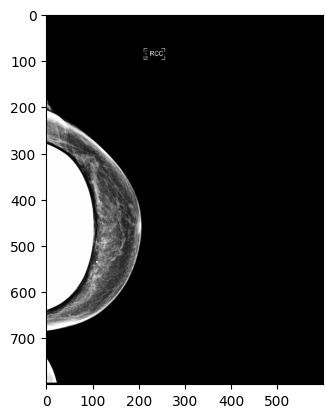

max: 1.0
min: -1.0
label: 0.0


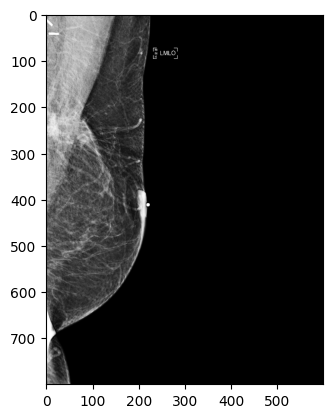

max: 1.0
min: -1.0
label: 1.0


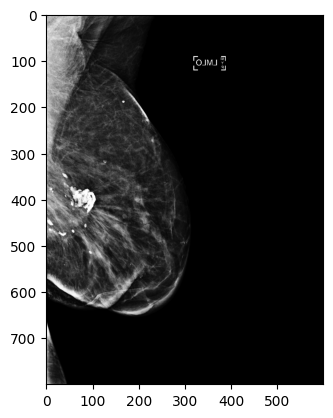

max: 1.0
min: -1.0
label: 1.0


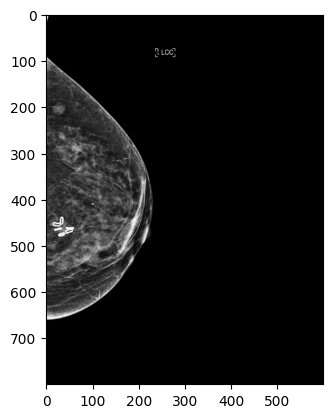

max: 1.0
min: -1.0
label: 0.0


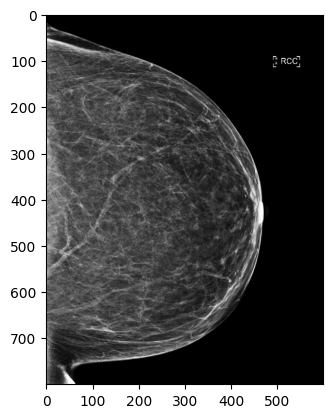

val
max: 1.0
min: -1.0
label: 1.0


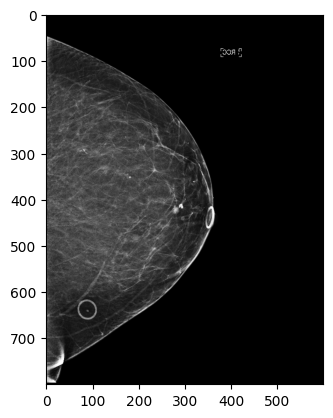

max: 1.0
min: -1.0
label: 1.0


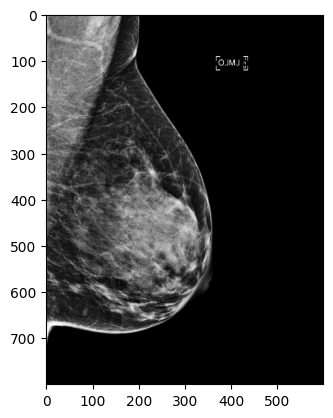

max: 1.0
min: -1.0
label: 1.0


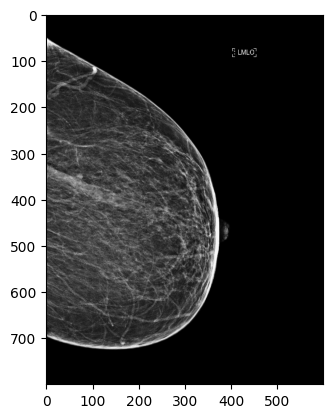

max: 1.0
min: -1.0
label: 1.0


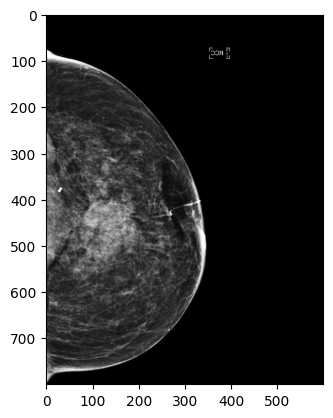

max: 1.0
min: -1.0
label: 1.0


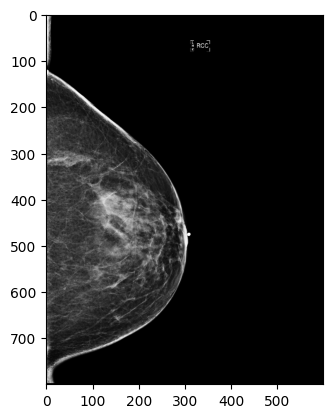

test
max: 1.0
min: -1.0
label: 1.0


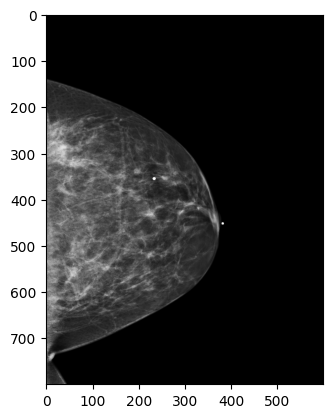

max: 1.0
min: -1.0
label: 1.0


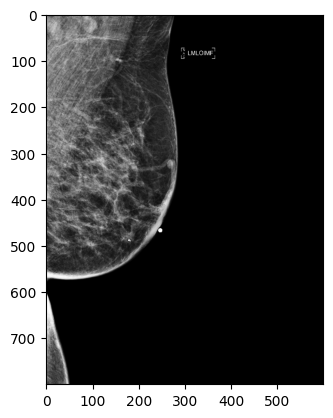

max: 1.0
min: -1.0
label: 1.0


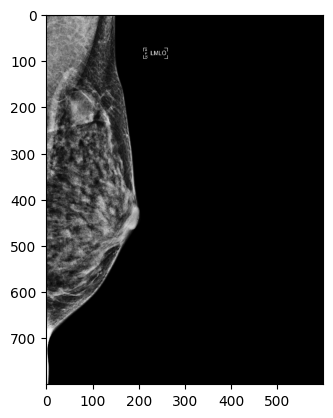

max: 1.0
min: -1.0
label: 1.0


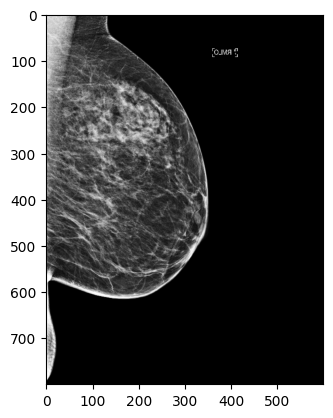

max: 1.0
min: -1.0
label: 1.0


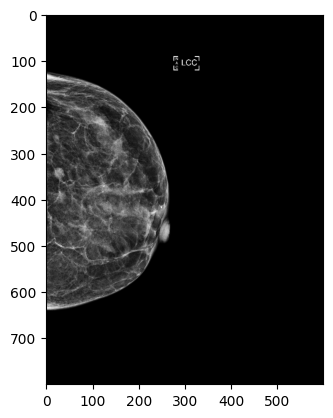

In [28]:
# let's visualize our datasets to make sure the images have been loaded correctly

def undo_img_preproc(img):
    img += 1.0
    img /= 2.0
    return img

dss = [train_ds.take(5), val_ds.take(5), test_ds.take(5)]
ds_names = ['train', 'val', 'test']

for ds, ds_name in zip(dss, ds_names):
    print(ds_name)
    for img, label in ds:
        img = np.array(img)
        # img = cv.imread(data.png_path)
        print('max:', img.max())
        print('min:', img.min())
        print('label:', label.numpy())
        plt.imshow(undo_img_preproc(img))
        plt.show()

In [23]:
batch_size = 20

# let's convert our dataframes to tensorflow datasets
train_bds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_bds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_bds = test_ds.batch(batch_size)

---
<a id="section_5"></a>
### 5. Define and compile the model

In [24]:
learning_rate = 0.0005
img_dims = (800, 600, 3)

def resnet_model(img_dims):
    """
    builds a ResNet50V2 model with the keras functional api
    """
    # define the model input
    inputs = tf.keras.layers.Input(img_dims)
    
    # define the ResNet50V2 model core
    # we're importing imagenet weights (even though we're working on a very different domain)
    # this is optional but in some cases it can help achieve a reasonable initialization
    x = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights=None,
        input_shape=img_dims,
        classifier_activation=None,
    )(inputs)

    # define classifier architecture
    x = tf.keras.layers.Conv2D(1, kernel_size=(3, 3))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # apply a sigmoid activation since our model is for binary classification
    outputs = tf.nn.sigmoid(x)
    
    # build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def add_regularizer(model, regularizer, verbose: bool = False):
    """
    adds a regularizer to all nested conv and dw conv layers in a model
    """
    # iterate over layers in the model
    for layer in model.layers:
        # if the layer has nested layers, recursively call the function
        if hasattr(layer, 'layers'):
            add_regularizer(layer, regularizer, verbose)
            
        # else, if the layer is a DepthwiseConv2D add the regularizer to depthwise_kernel
        elif isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            if verbose:
                print(f'regularizer added to layer {layer.name}')
            layer.add_loss(lambda x=layer.depthwise_kernel: regularizer(x))

        # else, if the layer is a Conv2D add the regularizer to kernel
        elif isinstance(layer, tf.keras.layers.Conv2D):
            if verbose:
                print(f'regularizer added to layer {layer.name}')
            layer.add_loss(lambda x=layer.kernel: regularizer(x))
            
def update_momentum(model, new_momentum, verbose: bool = False):
    """
    updates the momentum for all batch norm layers in a model.
    this isn't 100% necessary but can fix a bug that sometimes 
    occurs when loading models from keras where batch norm 
    layers don't work correctly during inference. 
    """
    # iterate over layers in the model
    for layer in model.layers:
        # if the layer has nested layers, recursively call the function
        if hasattr(layer, 'layers'):
            update_momentum(layer, new_momentum, verbose)
            
        # else, if the layer is a BatchNormalization update the momentum to new_momentum
        elif isinstance(layer, tf.keras.layers.BatchNormalization):
            if verbose:
                print(f"momentum updated from '{layer.momentum}' to '{new_momentum}' for layer {layer.name}")
            layer.momentum = new_momentum

# compile model
model = resnet_model(img_dims)

# update model momentum
update_momentum(model, 0.9, True)

# add l2 regularization to all nested layers in the model
# regularizer = tf.keras.regularizers.l1()
# add_regularizer(model, regularizer, True)

# define our model evaluation metrics
model_metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'), 
    tf.keras.metrics.AUC(name='auc'), 
    tf.keras.metrics.Precision(name='prec'), 
    tf.keras.metrics.Recall(name='rec')
]

# compile our model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=model_metrics
)

# build the model so we can view a summary of its architecture
model.build((None,) + img_dims)
model.summary()

momentum updated from '0.99' to '0.9' for layer conv2_block1_preact_bn
momentum updated from '0.99' to '0.9' for layer conv2_block1_1_bn
momentum updated from '0.99' to '0.9' for layer conv2_block1_2_bn
momentum updated from '0.99' to '0.9' for layer conv2_block2_preact_bn
momentum updated from '0.99' to '0.9' for layer conv2_block2_1_bn
momentum updated from '0.99' to '0.9' for layer conv2_block2_2_bn
momentum updated from '0.99' to '0.9' for layer conv2_block3_preact_bn
momentum updated from '0.99' to '0.9' for layer conv2_block3_1_bn
momentum updated from '0.99' to '0.9' for layer conv2_block3_2_bn
momentum updated from '0.99' to '0.9' for layer conv3_block1_preact_bn
momentum updated from '0.99' to '0.9' for layer conv3_block1_1_bn
momentum updated from '0.99' to '0.9' for layer conv3_block1_2_bn
momentum updated from '0.99' to '0.9' for layer conv3_block2_preact_bn
momentum updated from '0.99' to '0.9' for layer conv3_block2_1_bn
momentum updated from '0.99' to '0.9' for layer con

---
<a id="section_6"></a>
### 6. Train/evaluate the model.

Now that our model is defined and our dataset is prepared, we can train and evaluate its performance.

In [25]:
num_epochs = 30

model.fit(train_bds, epochs=num_epochs, validation_data=val_bds)

Epoch 1/30


2023-08-18 01:36:00.363074: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-08-18 01:36:02.244157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2023-08-18 01:36:03.877503: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-18 01:36:03.877562: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-08-18 01:36:03.878076: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-18 01:36:03.878143: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-08-18 01:36:03.973153: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

150/150 [==============================] - 177s 1s/step - loss: 0.6755 - accuracy: 0.5951 - auc: 0.6336 - prec: 0.6015 - rec: 0.5707 - val_loss: 1.2887 - val_accuracy: 0.4995 - val_auc: 0.6889 - val_prec: 0.4995 - val_rec: 1.0000
Epoch 2/30
150/150 [==============================] - 167s 1s/step - loss: 0.6541 - accuracy: 0.6165 - auc: 0.6579 - prec: 0.6242 - rec: 0.5913 - val_loss: 0.6827 - val_accuracy: 0.5821 - val_auc: 0.7024 - val_prec: 0.5516 - val_rec: 0.8725
Epoch 3/30
150/150 [==============================] - 169s 1s/step - loss: 0.6486 - accuracy: 0.6199 - auc: 0.6667 - prec: 0.6270 - rec: 0.5973 - val_loss: 0.6445 - val_accuracy: 0.6318 - val_auc: 0.7025 - val_prec: 0.5982 - val_rec: 0.8008
Epoch 4/30
150/150 [==============================] - 164s 1s/step - loss: 0.6432 - accuracy: 0.6222 - auc: 0.6771 - prec: 0.6233 - rec: 0.6233 - val_loss: 0.8950 - val_accuracy: 0.6000 - val_auc: 0.6555 - val_prec: 0.6701 - val_rec: 0.3924
Epoch 5/30
150/150 [===========================

In [ ]:
model.evaluate(test_bds)